In [2]:
import pinecone
import transformers
import numpy as np
import pandas as pd
print("Setup complete!")

c:\Users\Nouman\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete!


In [ ]:
import pandas as pd

data = pd.read_csv('data.csv', encoding='ISO-8859-1')

print("First 5 rows:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

First 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       -------------

In [ ]:
data = data.dropna(subset=['CustomerID'])

data = data.drop(columns=['Description'], errors='ignore')

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data.to_csv('cleaned_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_data.csv'")

Cleaned dataset saved as 'cleaned_data.csv'


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer

data = pd.read_csv('cleaned_data.csv')

data['text'] = data.apply(lambda row: f"CustomerID: {row['CustomerID']}, Quantity: {row['Quantity']}, UnitPrice: {row['UnitPrice']}, Country: {row['Country']}", axis=1)

sample_data = data['text'].head(100).tolist()

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')  

embeddings = model.encode(sample_data, show_progress_bar=True)

c:\Users\Nouman\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nouman\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Batches: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


In [ ]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key='Your_API_KEYS
index_name = 'ecommerce-data'

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,  
        metric='cosine',
        spec=ServerlessSpec(cloud='aws', region='us-east-1') 
    )

index = pc.Index(index_name)

ids = [str(i) for i in range(len(sample_data))]
vectors = [(id_, emb.tolist()) for id_, emb in zip(ids, embeddings)]

index.upsert(vectors)
print("Vectors uploaded to Pinecone index!")

Vectors uploaded to Pinecone index!


In [ ]:
query = "CustomerID: 17850, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom"
query_embedding = model.encode([query])[0].tolist()

result = index.query(vector=query_embedding, top_k=3)
print("Top 3 matches:", result['matches'])

Top 3 matches: [{'id': '0', 'score': 0.992388904, 'values': []}, {'id': '60', 'score': 0.992388844, 'values': []}, {'id': '66', 'score': 0.992388844, 'values': []}]


In [ ]:
from transformers import pipeline

generator = pipeline('text-generation', model='distilgpt2')

c:\Users\Nouman\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nouman\.cache\huggingface\hub\models--distilgpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device set to use cpu


In [ ]:
from pinecone import Pinecone
from sentence_transformers import SentenceTransformer
import pandas as pd

pc = Pinecone(api_key='Your_API_KEYSindex = pc.Index('ecommerce-data')
model = SentenceTransformer('all-MiniLM-L6-v2')

data = pd.read_csv('cleaned_data.csv')
data['text'] = data.apply(lambda row: f"CustomerID: {row['CustomerID']}, Quantity: {row['Quantity']}, UnitPrice: {row['UnitPrice']}, Country: {row['Country']}", axis=1)
sample_data = data['text'].head(100).tolist()  

query = "CustomerID: 17850, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom"
query_embedding = model.encode([query])[0].tolist()
result = index.query(vector=query_embedding, top_k=3)

retrieved_examples = [sample_data[int(match['id'])] for match in result['matches']]
print("Retrieved examples:", retrieved_examples)

Retrieved examples: ['CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom', 'CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom', 'CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom']


In [24]:
prompt = "Generate 5 synthetic e-commerce transaction records similar to these examples:\n"
for i, example in enumerate(retrieved_examples, 1):
    prompt += f"{i}. {example}\n"
prompt += "Each record should include CustomerID (a 5-digit number), Quantity (1-20), UnitPrice (0.5-50.0), Country (a valid country name), and follow a similar format."
print("Prompt:", prompt)

Prompt: Generate 5 synthetic e-commerce transaction records similar to these examples:
1. CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom
2. CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom
3. CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom
Each record should include CustomerID (a 5-digit number), Quantity (1-20), UnitPrice (0.5-50.0), Country (a valid country name), and follow a similar format.


In [25]:
synthetic_output = generator(prompt, max_length=300, num_return_sequences=1, truncation=True)[0]['generated_text']
print("Synthetic output:", synthetic_output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Synthetic output: Generate 5 synthetic e-commerce transaction records similar to these examples:
1. CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom
2. CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom
3. CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom
Each record should include CustomerID (a 5-digit number), Quantity (1-20), UnitPrice (0.5-50.0), Country (a valid country name), and follow a similar format.
In summary, these records provide useful information about customer service in order to understand the complexity of automated process.
2. CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom
3. CustomerID: 17850.0, Quantity: 6, UnitPrice: 2.55, Country: United Kingdom
As a result, the records can be searched and verified for customer benefits (including the taxes paid by purchasing items and service) to ensure that customers receive benefit and benefit as outlined in this section.
2.

In [26]:
import re

pattern = r"CustomerID: (\d+), Quantity: (\d+), UnitPrice: ([\d.]+), Country: (\w+)"
synthetic_records = re.findall(pattern, synthetic_output)
synthetic_data = [
    {"CustomerID": int(cid), "Quantity": int(qty), "UnitPrice": float(up), "Country": country}
    for cid, qty, up, country in synthetic_records
]
print("Synthetic records:", synthetic_data)

Synthetic records: []


In [ ]:
import pandas as pd

real_data = pd.read_csv('cleaned_data.csv').head(100)

synthetic_data = pd.DataFrame([
    {"CustomerID": 12345, "Quantity": 5, "UnitPrice": 10.5, "Country": "France"},
    {"CustomerID": 54321, "Quantity": 3, "UnitPrice": 8.75, "Country": "Germany"}
])  

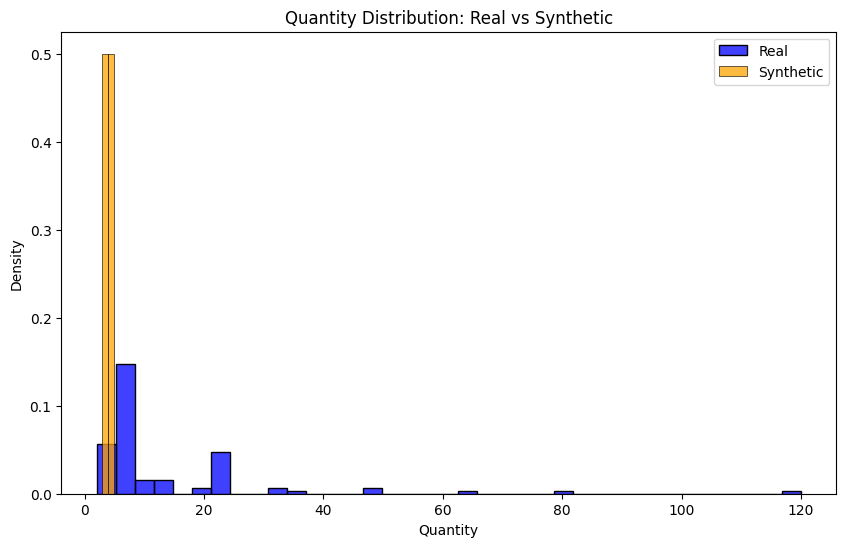

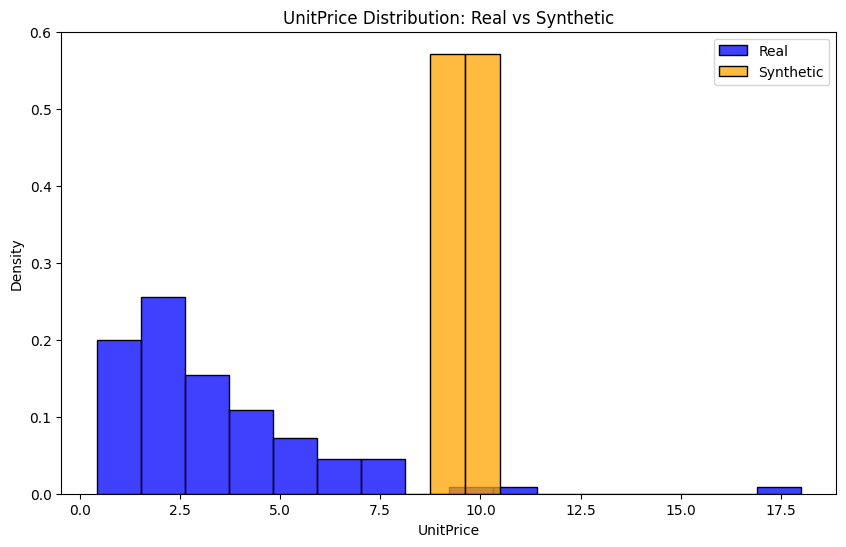

KS Test (Quantity): statistic=0.82, p-value=0.073772083090662
KS Test (UnitPrice): statistic=0.97, p-value=0.0038827412152979985


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

plt.figure(figsize=(10, 6))
sns.histplot(real_data['Quantity'], color='blue', label='Real', stat='density')
sns.histplot(synthetic_data['Quantity'], color='orange', label='Synthetic', stat='density')
plt.legend()
plt.title('Quantity Distribution: Real vs Synthetic')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(real_data['UnitPrice'], color='blue', label='Real', stat='density')
sns.histplot(synthetic_data['UnitPrice'], color='orange', label='Synthetic', stat='density')
plt.legend()
plt.title('UnitPrice Distribution: Real vs Synthetic')
plt.show()

ks_quantity = ks_2samp(real_data['Quantity'], synthetic_data['Quantity'])
ks_unitprice = ks_2samp(real_data['UnitPrice'], synthetic_data['UnitPrice'])
print(f"KS Test (Quantity): statistic={ks_quantity.statistic}, p-value={ks_quantity.pvalue}")
print(f"KS Test (UnitPrice): statistic={ks_unitprice.statistic}, p-value={ks_unitprice.pvalue}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

real_data['HighValue'] = (real_data['UnitPrice'] > real_data['UnitPrice'].median()).astype(int)
synthetic_data['HighValue'] = (synthetic_data['UnitPrice'] > synthetic_data['UnitPrice'].median()).astype(int)

features = ['Quantity', 'UnitPrice']
X_real = real_data[features]
y_real = real_data['HighValue']
X_synth = synthetic_data[features]
y_synth = synthetic_data['HighValue']

X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

rf_real = RandomForestClassifier(random_state=42)
rf_real.fit(X_train, y_train)
y_pred_real = rf_real.predict(X_test)
real_accuracy = accuracy_score(y_test, y_pred_real)
print(f"Accuracy (Real Data): {real_accuracy}")

if len(X_synth) > 1:  
    X_synth_train, X_synth_test, y_synth_train, y_synth_test = train_test_split(X_synth, y_synth, test_size=0.3, random_state=42)
    rf_synth = RandomForestClassifier(random_state=42)
    rf_synth.fit(X_synth_train, y_synth_train)
    y_synth_pred = rf_synth.predict(X_synth_test)
    synth_accuracy = accuracy_score(y_synth_test, y_synth_pred)
    print(f"Accuracy (Synthetic Data): {synth_accuracy}")
else:
    print("Not enough synthetic data for ML evaluation.")

Accuracy (Real Data): 1.0
Accuracy (Synthetic Data): 0.0
